In [1]:
library("MetaCyto")
library(flowCore)
library(dplyr)
library(ggplot2)
library(tidyr)
library(CytoDx)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'dplyr':
  method               from  
  as.data.frame.tbl_df tibble

Attaching package: ‘dplyr’

The following object is masked from ‘package:flowCore’:

    filter

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
##### change cell markers #####
cytof_files = read.csv("result_05_cytof_files.csv")
marker_list = c('VIABILITY',  'TCRGD', 'IGD', 'HLADR', 'DNA2', 
                'DNA1', 'CELL_LENGTH', 'CD94', 'CD85J', 'CD8', 'CD56', 
                'CD45RA', 'CD4', 'CD38', 'CD33', 'CD3', 'CD28', 'CD27', 'CD25', 
                'CD24', 'CD20', 'CD19', 'CD161', 'CD16', 'CD14', 'CD127', 'CCR7')
cytof_files = cytof_files%>%filter(!is.na(CMV_Ab))

In [3]:
if(FALSE){
    dir.create("standard_fcs")
for(i in 1:nrow(cytof_files)){
    f = read.FCS(file.path("CyTOF_data",cytof_files$name[i]))
    cn = MetaCyto::markerFinder(f)
    cn = gsub('DEAD','VIABILITY',cn)
    cn = gsub('EVENT_LENGTH','CELL_LENGTH',cn)

    expr = exprs(f)
    colnames(expr) = toupper(cn)
    if(length(setdiff(marker_list, colnames(expr)))==0){
        expr = expr[sample(size = 10000,x = 1:nrow(expr), replace = T),marker_list]
        #expr = apply(expr, 2, scale)
        expr = flowFrame(expr)
        write.FCS(expr,file.path("standard_fcs",cytof_files$name[i]))
    }

}
}


In [4]:
fileName = list.files("standard_fcs", full.names = T)
fileName_core = basename(fileName)
t1 = data.frame(name=fileName_core,full_name = fileName)
fcs_info = inner_join(cytof_files,t1,by = "name")

Warning message:
“Column `name` joining factors with different levels, coercing to character vector”

In [5]:
# Find the training data
train_info <- subset(fcs_info,!fcs_info$study_accession%in%c("SDY515","SDY519"))

# Read cytometry files using fcs2DF function

train_data <- fcs2DF(fcsFiles=train_info$full_name,y=(train_info$CMV_Ab>2),
                     assay="CyTOF",b=1/5,
                     excludeTransformParameters=c("FSC-A","FSC-W","FSC-H","Time","CELL_LENGTH"))
x_train <- pRank(x=train_data[,1:27],xSample=train_data$xSample)
x_train <- model.matrix(~.*.,x_train)
#x_train <- model.matrix(~.,train_data[,1:27])

In [6]:
# Build predictive model using the CytoDx.fit function
fit <- CytoDx.fit(x=x_train,
                  y=(train_data$y*1),
                  xSample=train_data$xSample,
                  family = "binomial",reg = F)

In [7]:
# Find the test data
test_info <- subset(fcs_info,fcs_info$study_accession%in%c("SDY519"))

# Read cytometry files using fcs2DF function

test_data <- fcs2DF(fcsFiles=test_info$full_name,y=(test_info$CMV_Ab>2),
                     assay="CyTOF",b=1/5,
                     excludeTransformParameters=c("FSC-A","FSC-W","FSC-H","Time","CELL_LENGTH"))
x_test <- pRank(x=test_data[,1:27],xSample=test_data$xSample)
x_test <- model.matrix(~.*.,x_test)
#x_test <- model.matrix(~.,test_data[,1:27])

In [8]:
pred <- CytoDx.pred(fit,xNew=x_test,xSampleNew=test_data$xSample)

In [9]:
pred$xNew.Pred.sample[1:5,]

,sample,y.Pred.s0
standard_fcs/072212-Study18-11-18214_cct.523255.fcs,standard_fcs/072212-Study18-11-18214_cct.523255.fcs,0.2641829
standard_fcs/072212-Study18-11-18217_cct.523256.fcs,standard_fcs/072212-Study18-11-18217_cct.523256.fcs,0.2739051
standard_fcs/071712-Mike-Study 18-2011-18173_cells_found.523257.fcs,standard_fcs/071712-Mike-Study 18-2011-18173_cells_found.523257.fcs,0.4885349
standard_fcs/072712-Mike-Study 18-2011-18174_cells_found.523258.fcs,standard_fcs/072712-Mike-Study 18-2011-18174_cells_found.523258.fcs,0.5791877
standard_fcs/072412-Mike-Study 18-2011-18175_cells_found.523259.fcs,standard_fcs/072412-Mike-Study 18-2011-18175_cells_found.523259.fcs,0.2516454


In [10]:
pred = inner_join(test_info,pred$xNew.Pred.sample,by = c("full_name"="sample"))

Warning message:
“Column `full_name`/`sample` joining factors with different levels, coercing to character vector”


	Welch Two Sample t-test

data:  pred$y.Pred.s0 by pred$CMV_Ab > 2
t = -8.3705, df = 65.847, p-value = 5.851e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4062630 -0.2497756
sample estimates:
mean in group FALSE  mean in group TRUE 
          0.4279952           0.7560145 


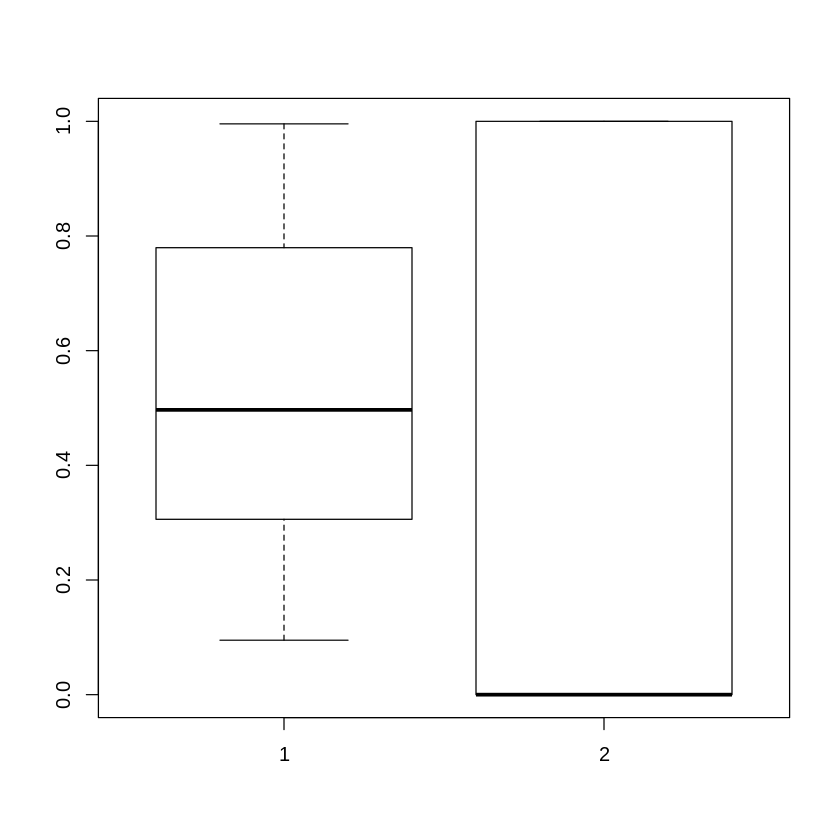

In [11]:
boxplot(pred$y.Pred.s0,pred$CMV_Ab>2)
t.test(pred$y.Pred.s0~(pred$CMV_Ab>2))

In [12]:
t1 = data.frame(prob = pred$y.Pred.s0, truth = pred$CMV_Ab>2)
write.csv(t1,"Result_10_cytodx_text.csv",row.names=F)